In [35]:
# Import All Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# Johnson & Johnson Sales Data

In [36]:
# Load and preprocess
df = pd.read_csv("jj.csv")
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

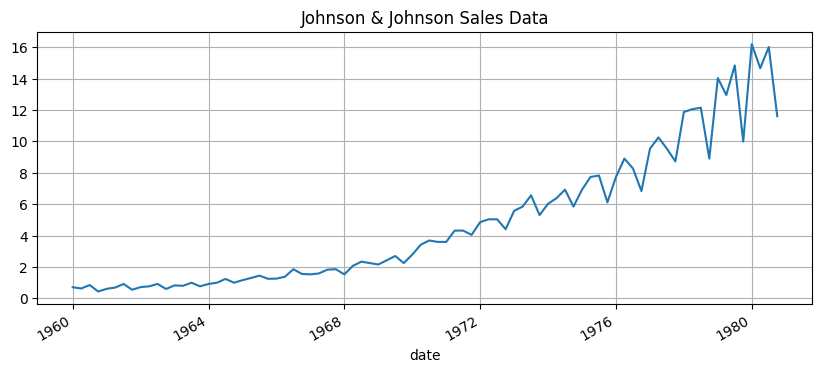

In [37]:
# Initial plot
plt.figure(figsize=(10,4))
df['data'].plot(title='Johnson & Johnson Sales Data')
plt.grid()
plt.show()

In [38]:
# ADF Test
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] < 0.05

print("\nADF Test before differencing:")
adf_test(df['data'])


ADF Test before differencing:
ADF Statistic: 2.7420165734574744
p-value: 1.0


False

In [39]:
# Differencing to make stationary
df['diff'] = df['data'].diff().dropna()

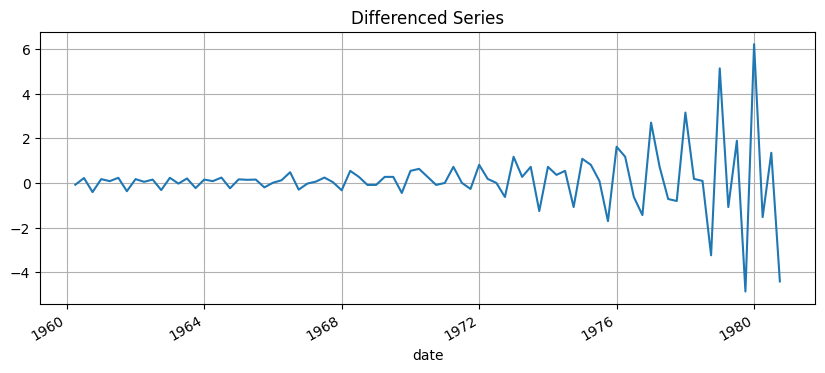


ADF Test after differencing:
ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305


np.False_

In [40]:
plt.figure(figsize=(10,4))
df['diff'].dropna().plot(title='Differenced Series')
plt.grid()
plt.show()

print("\nADF Test after differencing:")
adf_test(df['diff'].dropna())

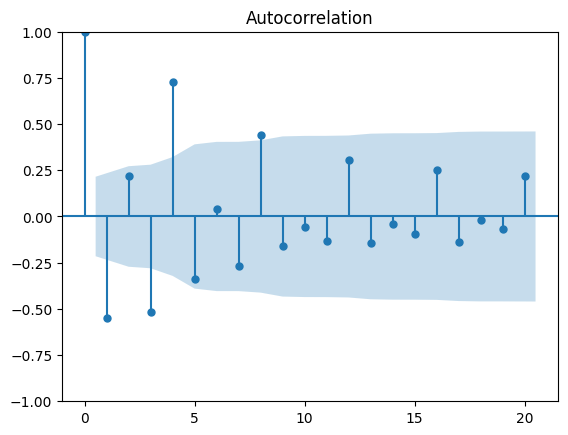

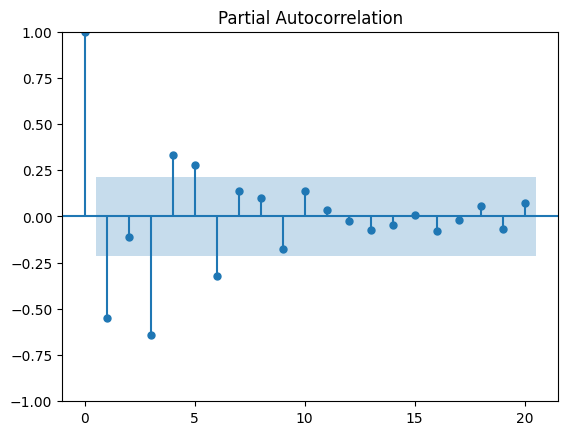

In [41]:
# ACF and PACF plots
plot_acf(df['diff'].dropna(), lags=20)
plot_pacf(df['diff'].dropna(), lags=20)
plt.show()

In [42]:
# Fit ARIMA model
arima_model = ARIMA(df['data'], order=(1,1,1)).fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   84
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -128.371
Date:                Thu, 10 Apr 2025   AIC                            262.742
Time:                        13:10:15   BIC                            269.998
Sample:                             0   HQIC                           265.657
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3277      0.090     -3.657      0.000      -0.503      -0.152
ma.L1         -0.4313      0.093     -4.662      0.000      -0.613      -0.250
sigma2         1.2819      0.164      7.814      0.0

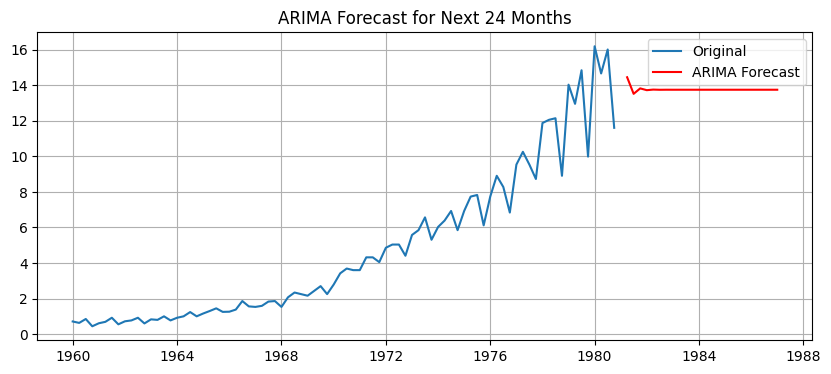

In [43]:
# Forecast with ARIMA (24 months)
arima_forecast = arima_model.forecast(steps=24)

plt.figure(figsize=(10,4))
plt.plot(df['data'], label='Original')
plt.plot(pd.date_range(df.index[-1], periods=25, freq='Q')[1:], arima_forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast for Next 24 Months')
plt.grid()
plt.show()

In [44]:
# Evaluation using last few known points
train, test = df['data'][:-24], df['data'][-24:]
test_model = ARIMA(train, order=(1,1,1)).fit()
test_forecast = test_model.forecast(steps=24)
rmse = sqrt(mean_squared_error(test, test_forecast))
mae = mean_absolute_error(test, test_forecast)
print(f"ARIMA RMSE: {rmse}, MAE: {mae}")

ARIMA RMSE: 5.334467158162614, MAE: 4.444673795110898


In [45]:
# Prepare data for LSTM and GRU
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['data']])

In [46]:
# Sequence generation
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [47]:
n_steps = 5
X, y = create_sequences(data_scaled, n_steps)

In [48]:
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


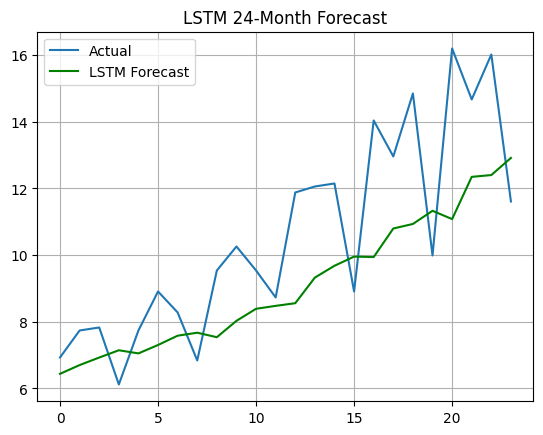

In [49]:
# LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=200, verbose=0)

lstm_preds = lstm_model.predict(X_test)
lstm_preds_inv = scaler.inverse_transform(lstm_preds)
y_test_inv = scaler.inverse_transform(y_test)

plt.plot(y_test_inv, label='Actual')
plt.plot(lstm_preds_inv, label='LSTM Forecast', color='green')
plt.title('LSTM 24-Month Forecast')
plt.legend()
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


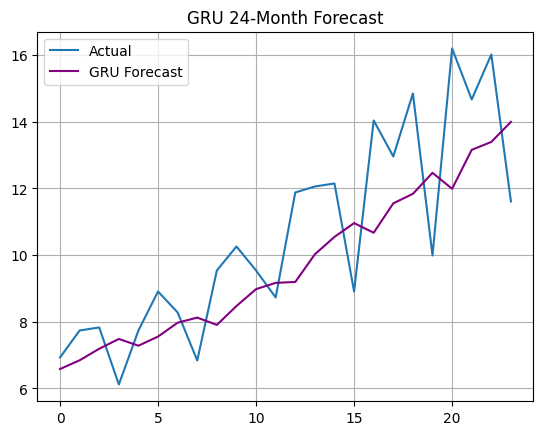

In [50]:
# GRU Model
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(n_steps, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=200, verbose=0)

gru_preds = gru_model.predict(X_test)
gru_preds_inv = scaler.inverse_transform(gru_preds)

plt.plot(y_test_inv, label='Actual')
plt.plot(gru_preds_inv, label='GRU Forecast', color='purple')
plt.title('GRU 24-Month Forecast')
plt.legend()
plt.grid()
plt.show()

In [51]:
# Evaluation for NN models
print("LSTM RMSE:", sqrt(mean_squared_error(y_test_inv, lstm_preds_inv)))
print("GRU RMSE:", sqrt(mean_squared_error(y_test_inv, gru_preds_inv)))
print("LSTM MAE:", mean_absolute_error(y_test_inv, lstm_preds_inv))
print("GRU MAE:", mean_absolute_error(y_test_inv, gru_preds_inv))

LSTM RMSE: 2.313302299800679
GRU RMSE: 1.9640120088006658
LSTM MAE: 1.9316500151723226
GRU MAE: 1.6847255805562338


# Amazon Monthly Average Close Price Dataset

In [52]:
# Load data
amzn = pd.read_csv("AMZN.csv")
amzn['Date'] = pd.to_datetime(amzn['Date'])
amzn.set_index('Date', inplace=True)
amzn = amzn[['Close']]

In [53]:
# Resample to monthly
monthly_amzn = amzn.resample('M').mean()

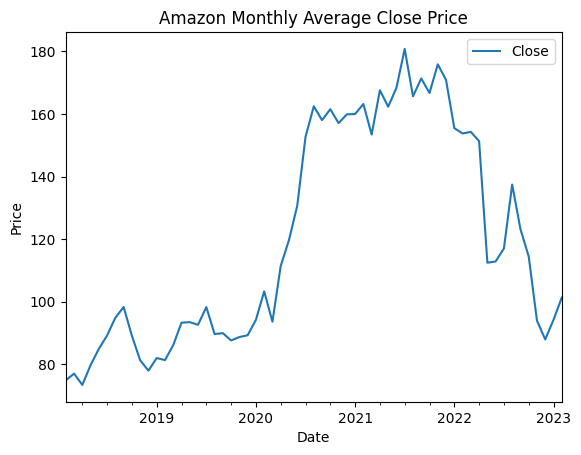

In [54]:
# Initial plot
monthly_amzn.plot(title="Amazon Monthly Average Close Price")
plt.ylabel("Price")
plt.show()

In [55]:
# ADF Test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    return result[1]

p_val = adf_test(monthly_amzn['Close'])

ADF Statistic: -1.4203009804386069
p-value: 0.5725058112187187


In [56]:
# Differencing if non-stationary
if p_val > 0.05:
    monthly_amzn_diff = monthly_amzn.diff().dropna()
else:
    monthly_amzn_diff = monthly_amzn

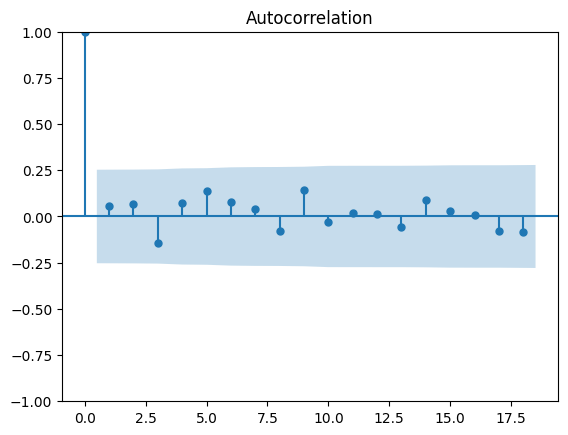

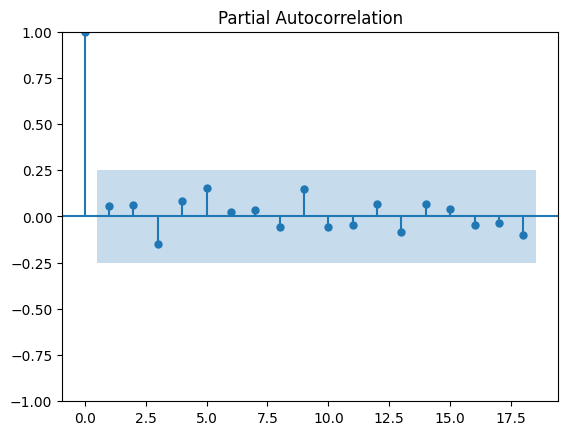

In [57]:
# ACF/PACF Plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(monthly_amzn_diff)
plt.show()
plot_pacf(monthly_amzn_diff)
plt.show()

In [58]:
# ARIMA model
model_arima = ARIMA(monthly_amzn, order=(1,1,1))
result_arima = model_arima.fit()
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                   61
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -222.201
Date:                Thu, 10 Apr 2025   AIC                            450.401
Time:                        13:10:57   BIC                            456.684
Sample:                    02-28-2018   HQIC                           452.859
                         - 02-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7382      2.161     -0.342      0.733      -4.974       3.498
ma.L1          0.7166      2.257      0.317      0.751      -3.707       5.140
sigma2        96.4236     11.334      8.507      0.0

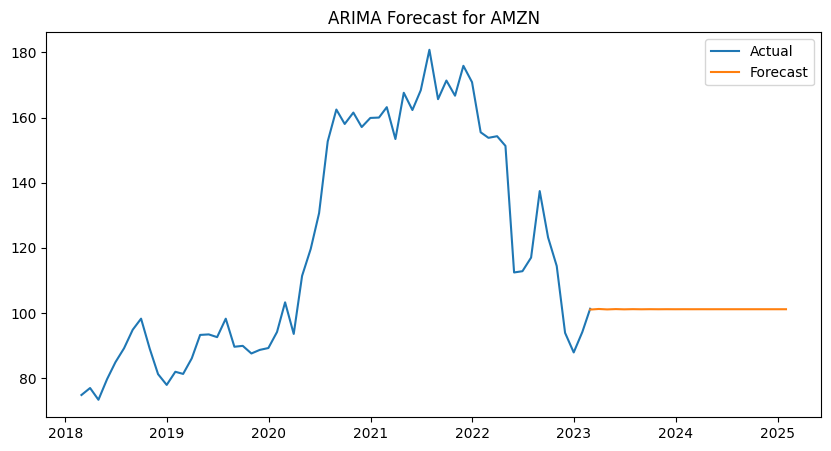

In [59]:
# Forecast 24 months
forecast = result_arima.forecast(steps=24)
plt.figure(figsize=(10,5))
plt.plot(monthly_amzn, label='Actual')
plt.plot(pd.date_range(monthly_amzn.index[-1], periods=24, freq='M'), forecast, label='Forecast')
plt.legend()
plt.title("ARIMA Forecast for AMZN")
plt.show()

In [60]:
# Evaluation
train = monthly_amzn[:-24]
test = monthly_amzn[-24:]
model_eval = ARIMA(train, order=(1,1,1)).fit()
pred_eval = model_eval.forecast(steps=24)
print("RMSE:", sqrt(mean_squared_error(test, pred_eval)))
print("MAE:", mean_absolute_error(test, pred_eval))

RMSE: 38.33253901385177
MAE: 27.965452466026296


In [61]:
# LSTM / GRU requires scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(monthly_amzn)

In [62]:
# Prepare data for RNN
X, y = [], []
for i in range(12, len(data_scaled)):
    X.append(data_scaled[i-12:i])
    y.append(data_scaled[i])
X, y = np.array(X), np.array(y)

In [63]:
X_train, y_train = X[:-24], y[:-24]
X_test, y_test = X[-24:], y[-24:]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


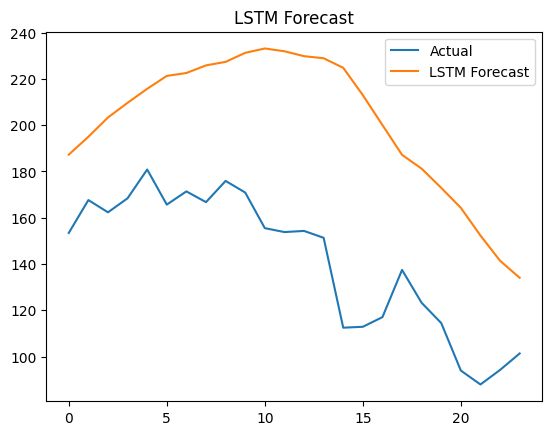

In [64]:
# LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(12, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=100, verbose=0)

lstm_preds = model_lstm.predict(X_test)
lstm_preds_rescaled = scaler.inverse_transform(lstm_preds)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.plot(y_test_rescaled, label='Actual')
plt.plot(lstm_preds_rescaled, label='LSTM Forecast')
plt.legend()
plt.title("LSTM Forecast")
plt.show()

In [65]:
print("LSTM RMSE:", sqrt(mean_squared_error(y_test_rescaled, lstm_preds_rescaled)))
print("LSTM MAE:", mean_absolute_error(y_test_rescaled, lstm_preds_rescaled))

LSTM RMSE: 63.55591364540834
LSTM MAE: 60.02599991060563


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


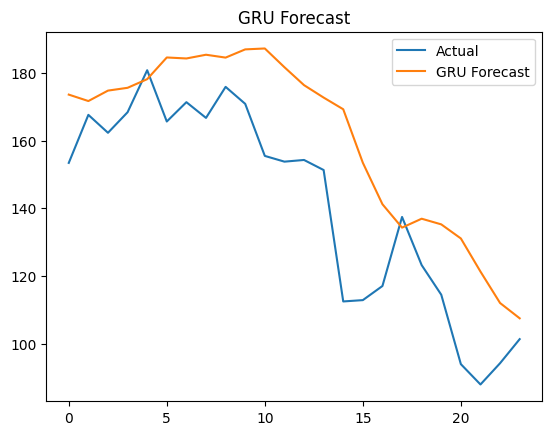

In [66]:
# GRU Model
model_gru = Sequential()
model_gru.add(GRU(50, activation='relu', input_shape=(12, 1)))
model_gru.add(Dense(1))
model_gru.compile(optimizer='adam', loss='mse')
model_gru.fit(X_train, y_train, epochs=100, verbose=0)

gru_preds = model_gru.predict(X_test)
gru_preds_rescaled = scaler.inverse_transform(gru_preds)

plt.plot(y_test_rescaled, label='Actual')
plt.plot(gru_preds_rescaled, label='GRU Forecast')
plt.legend()
plt.title("GRU Forecast")
plt.show()

In [67]:
print("GRU RMSE:", sqrt(mean_squared_error(y_test_rescaled, gru_preds_rescaled)))
print("GRU MAE:", mean_absolute_error(y_test_rescaled, gru_preds_rescaled))

GRU RMSE: 23.72773678811599
GRU MAE: 19.943008267739515
